In [1]:
%matplotlib inline
import os
import glob
import xgboost
import numpy as np
from pylab import *
import pandas as pd
import seaborn as sns
import SimpleITK as sitk
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression,Lasso,LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier, AdaBoostClassifier,VotingClassifier
from sklearn.model_selection import GridSearchCV,KFold, cross_val_predict,StratifiedKFold,train_test_split,cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,plot_confusion_matrix,auc,plot_roc_curve,ConfusionMatrixDisplay,mean_squared_error
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler,RobustScaler,MinMaxScaler
from sklearn.impute import SimpleImputer
import missingno as msno
from sklearn.decomposition import PCA

RANDOM_NUM = 24


In [2]:
#导入数据
df = pd.read_excel("./features_total.xlsx")
df

,origin_data,segment,label,log-sigma-1-0-mm-3D_firstorder_10Percentile,log-sigma-1-0-mm-3D_firstorder_90Percentile,log-sigma-1-0-mm-3D_firstorder_Energy,log-sigma-1-0-mm-3D_firstorder_Entropy,log-sigma-1-0-mm-3D_firstorder_InterquartileRange,log-sigma-1-0-mm-3D_firstorder_Kurtosis,log-sigma-1-0-mm-3D_firstorder_Maximum,...,wavelet-LLL_glszm_LargeAreaLowGrayLevelEmphasis,wavelet-LLL_glszm_LowGrayLevelZoneEmphasis,wavelet-LLL_glszm_SizeZoneNonUniformity,wavelet-LLL_glszm_SizeZoneNonUniformityNormalized,wavelet-LLL_glszm_SmallAreaEmphasis,wavelet-LLL_glszm_SmallAreaHighGrayLevelEmphasis,wavelet-LLL_glszm_SmallAreaLowGrayLevelEmphasis,wavelet-LLL_glszm_ZoneEntropy,wavelet-LLL_glszm_ZonePercentage,wavelet-LLL_glszm_ZoneVariance
0,BAIYONGSHENG1.nii.gz,BAIYONGSHENG1_0001.nii.gz,0,-83.646100,129.892889,3.494216e+08,3.671517,138.392548,2.055144,242.076202,...,0.010379,0.006462,157.655738,0.646130,0.830911,1100.878170,0.005993,6.297352,0.741641,0.759792
1,BAIYONGSHENG1.nii.gz,BAIYONGSHENG1_0002.nii.gz,0,33.181335,104.811768,1.769276e+08,2.265480,44.377622,2.627274,135.455536,...,0.121409,0.027931,46.466667,0.516296,0.744204,187.986348,0.023194,5.348588,0.576923,2.440000
2,BAIYONGSHENG1.nii.gz,BAIYONGSHENG1_0003.nii.gz,0,-25.872870,91.437953,3.217902e+08,2.877229,57.773559,3.219004,166.114014,...,0.053080,0.012606,78.317919,0.452705,0.697914,406.532998,0.005743,6.152041,0.578595,1.966654
3,BAIYONGSHENG1.nii.gz,BAIYONGSHENG1_0004.nii.gz,0,-38.884734,61.843832,3.046141e+08,2.649633,57.832117,2.529064,98.607384,...,0.081152,0.035130,77.934911,0.461153,0.704980,236.150681,0.031275,6.022388,0.567114,2.228003
4,BAIYONGSHENG1.nii.gz,BAIYONGSHENG1_0005.nii.gz,0,-39.876049,89.615274,2.950158e+08,2.938735,68.926260,2.499383,160.474472,...,0.026332,0.013702,101.128342,0.540793,0.764011,218.549337,0.012071,5.641285,0.670251,0.923732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,ZHANGXINJIE3.nii.gz,ZHANGXINJIE3_0001.nii.gz,1,-32.909097,27.686535,1.687229e+09,2.097381,28.902321,4.818150,109.535469,...,0.092261,0.005658,240.598086,0.383729,0.643737,406.881171,0.004356,6.922494,0.369476,21.173849
611,ZHANGXINJIE3.nii.gz,ZHANGXINJIE3_0002.nii.gz,1,-24.663914,20.473344,6.154775e+08,1.642612,19.232399,4.832718,73.651154,...,2.101218,0.035991,34.552000,0.276416,0.540634,38.857015,0.026374,5.651746,0.201613,126.134400
612,ZHANGXINJIE3.nii.gz,ZHANGXINJIE3_0003.nii.gz,1,-20.707914,27.384938,8.112748e+08,1.783582,25.359391,5.567235,101.130440,...,0.708453,0.017436,42.206704,0.235792,0.485666,120.397243,0.010413,6.327443,0.221535,65.713492
613,ZHANGXINJIE3.nii.gz,ZHANGXINJIE3_0004.nii.gz,1,-30.121584,32.053389,4.620809e+08,2.242057,34.537393,5.716176,83.379738,...,0.131325,0.019553,78.203980,0.389075,0.646984,290.922954,0.013799,6.389663,0.435065,7.801441


In [ ]:
#异常值处理
def outliers(x):   #传入某变量  
    mean_value = x.mean()   #计算该变量的均值  
    std_value = x.std()   #计算该变量的标准差  
    rule = (mean_value - 3 * std_value > x) | (x.mean() + 3 * x.std() < x)   #处于(mean-3std,mean+3std)区间外的数据为异常值
    index = np.arange(x.shape[0])[rule]   #获取异常值的行位置索引  
    x = x.replace(x.iloc[index],nan,inplace=True)   #获取异常值的数据 
    return x   #返回异常值的数据

for i in range(117):
    outliers(df[df.columns[i+1]])

In [ ]:
#缺失值填充
df_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
df_miss = pd.DataFrame(df_mean.fit_transform(df),columns=df.columns)
df_miss

In [4]:
#划分数据和标签
df_train, df_test = train_test_split(df, test_size=0.3, random_state=RANDOM_NUM, stratify=df['label'])

df_miss = df_train
target=df_miss[list(df_miss.columns)[2:3]]
features=df_miss[list(df_miss.columns)[3:]]
#数据标准化
scaler = StandardScaler()
#scaler = MinMaxScaler()
X_train = scaler.fit_transform(features)
X_train=pd.DataFrame(X_train,columns=df.columns[3:])
y_train = target

In [ ]:
#所有数据分类十折交叉验证
def Kfold_model_confusion(model, X, y, name):
    cv = StratifiedKFold(n_splits=10,shuffle=True,random_state=1234)
    accuracy = cross_val_score(model,X, y, cv=cv,scoring="accuracy",n_jobs=-1)
    auc = cross_val_score(model,X, y, cv=cv,scoring="roc_auc",n_jobs=-1)
    recall = cross_val_score(model,X, y, cv=cv,scoring="recall",n_jobs=-1)
    precision = cross_val_score(model,X, y, cv=cv,scoring="precision",n_jobs=-1)
    f1 = cross_val_score(model,X, y, cv=cv,scoring="f1",n_jobs=-1)
    result_dict = {'Accuracy': [accuracy.mean()], 
                  'Auc': [auc.mean()], 
                  'Recall': [recall.mean()], 
                  'Precision': [precision.mean()],
                  'F1 score': [f1.mean()]}
    result = pd.DataFrame(result_dict, index=[name])
    return result

#创建分类器
lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier()
svm_clf = SVC(probability=True)
forest_clf = RandomForestClassifier(random_state=0,n_jobs=-1,class_weight="balanced")
gra_clf = GradientBoostingClassifier(n_estimators=500)
ada_clf = AdaBoostClassifier(n_estimators=500)
dt_clf = DecisionTreeClassifier(random_state=1234)
lgbm_clf = LGBMClassifier(n_estimators=500)
xgb_clf = xgboost.XGBClassifier(n_estimators=500, learning_rate=0.2, 
                                gamma=0.5, max_depth=20, verbosity=0)
en_clf = VotingClassifier(estimators=[('rf', forest_clf), ('gb', gra_clf), ('xgb', xgb_clf), ('lgbm', lgbm_clf)],
                         voting='soft',weights=[4, 3, 4, 5])


#训练分类器并输出结果
result3 = Kfold_model_confusion(lr_clf, X_train, y_train, 'Logistic Regression')
result3 = pd.concat([result3, Kfold_model_confusion(knn_clf, X_train, y_train, 'KNN')])
result3 = pd.concat([result3, Kfold_model_confusion(svm_clf, X_train, y_train, 'SVM')])
result3 = pd.concat([result3, Kfold_model_confusion(forest_clf, X_train, y_train, 'Random Forest')])
result3 = pd.concat([result3, Kfold_model_confusion(gra_clf, X_train, y_train, 'Gradient Boosting')])
result3 = pd.concat([result3, Kfold_model_confusion(ada_clf, X_train, y_train, 'AdaBoosting')])
result3 = pd.concat([result3, Kfold_model_confusion(dt_clf, X_train, y_train, 'Decision Tree')])
result3 = pd.concat([result3, Kfold_model_confusion(lgbm_clf,X_train, y_train, 'LGBM')])
result3 = pd.concat([result3, Kfold_model_confusion(xgb_clf, X_train, y_train, 'XGBoost')])
result3 = pd.concat([result3, Kfold_model_confusion(en_clf,X_train, y_train, 'Ensemble')])
result3

In [ ]:
#混淆矩阵
clf=en_clf
cons = 0
#target_ = np.array(target, dtype = int)
cv = StratifiedKFold(n_splits=10,shuffle=True,random_state=1)
for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    clf.fit(X_train.iloc[train], y_train.iloc[train])
    class_names=['0','1']
    a=confusion_matrix(y_train.iloc[test],(clf.fit(X_train.iloc[train], y_train.iloc[train])).predict(X_train.iloc[test]))
    cons=cons+a
disp = ConfusionMatrixDisplay(confusion_matrix=cons,display_labels=class_names)
disp.plot(cmap = 'Blues')
plt.show()  

In [ ]:
cv = StratifiedKFold(n_splits=10,shuffle=True,random_state=1)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots()   
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    clf.fit(X_train.iloc[train], y_train.iloc[train])
    viz = plot_roc_curve(clf, X_train.iloc[test],y_train.iloc[test])
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2,color='r', 
         alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

ax.plot(mean_fpr, mean_tpr, 
        label=r'AUC = %0.2f'% (mean_auc),
        lw=2, alpha=.8)

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic")
ax.legend(loc="lower right")

plt.show()

Computing regularization path using the coordinate descent lasso...


C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1571: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.966e-03, tolerance: 8.279e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.343e-02, tolerance: 8.279e-03
  coef_, l1_reg, l2_reg, X, y, m

0.003708836791415645


(0.00019385985188573768,
 0.2312815385022193,
 0.009951282875935816,
 0.89557571052427)

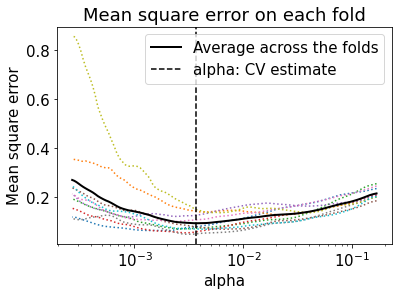

In [5]:
import time

EPSILON = 1e-4
# LassoCV: coordinate descent

# Compute paths
print("Computing regularization path using the coordinate descent lasso...")
t1 = time.time()
model = LassoCV(cv=10).fit(X_train, y_train)
t_lasso_cv = time.time() - t1

# Display results
plt.figure()
#设置字体大小
matplotlib.rcParams.update({'font.size': 15})
ymin, ymax = 2300, 3800
plt.semilogx(model.alphas_ + EPSILON, model.mse_path_, ":")
plt.plot(
    model.alphas_ + EPSILON,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_ + EPSILON, linestyle="--", color="k", label="alpha: CV estimate"
)
print(model.alpha_+ EPSILON)
plt.legend()

plt.xlabel('alpha')
plt.ylabel("Mean square error")
plt.title(
    "Mean square error on each fold"
    
)
plt.axis("tight")
#plt.ylim(ymin, ymax)

C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.771e-01, tolerance: 9.299e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.974e-01, tolerance: 9.299e-03
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasin

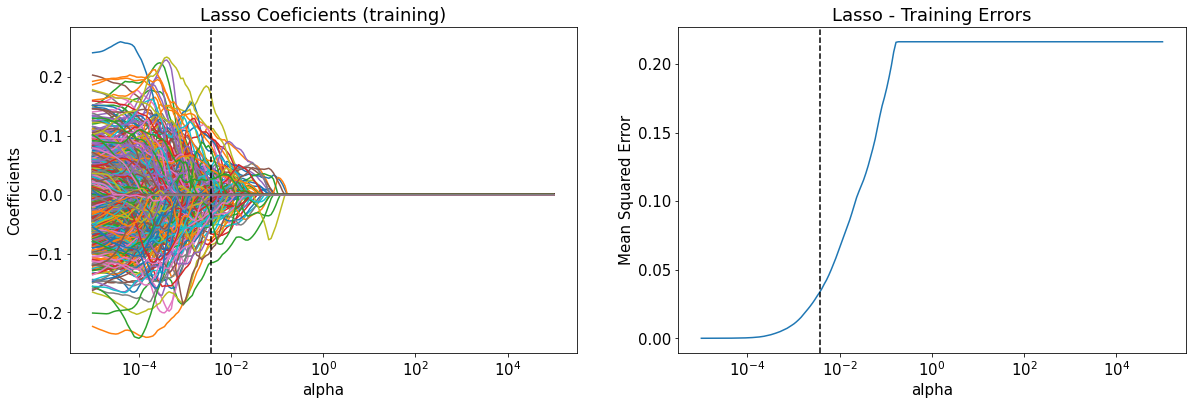

In [6]:
model_lasso = Lasso()
coeficents = []
errors_train = []
#errors_test = []

alphas = np.logspace(-5, 5, 200)
for a in alphas:
    model_lasso.set_params(alpha=a)
    model_lasso.fit(X_train, y_train)
    coeficents.append(model_lasso.coef_)
    errors_train.append(mean_squared_error(y_train, model_lasso.predict(X_train)))
#    errors_test.append(mean_squared_error(diabetes_y_test,model_lasso.predict(diabetes_X_test)))

plt.figure(figsize=(20, 6))
matplotlib.rcParams.update({'font.size': 15})
plt.subplot(121)
ax = plt.gca()
ax.plot(alphas, coeficents)
ax.set_xscale('log')
plt.axvline(model.alpha_ + EPSILON, linestyle="--", color="k", label="alpha: CV estimate")
plt.xlabel('alpha')
plt.ylabel('Coefficients')
plt.title('Lasso Coeficients (training)')
plt.axis('tight')

plt.subplot(122)
ax = plt.gca()
ax.plot(alphas, errors_train,linestyle="-", label="Train")
#ax.plot(alphas, errors_test,linestyle="--", label="Test")
ax.set_xscale('log')
plt.axvline(model.alpha_ + EPSILON, linestyle="--", color="k", label="alpha: CV estimate")
plt.xlabel('alpha')
plt.ylabel('Mean Squared Error')
plt.title('Lasso - Training Errors')
plt.axis('tight')

plt.show()

In [9]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
feature_selection= SelectFromModel(Lasso(alpha=model.alpha_,random_state=RANDOM_NUM)) 
feature_selection.fit(X_train,y_train)
selected_feat = X_train.columns[(feature_selection.get_support())]
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
selected_feat

total features: 1218
selected features: 154


Index(['log-sigma-1-0-mm-3D_firstorder_Kurtosis',
       'log-sigma-1-0-mm-3D_firstorder_Maximum',
       'log-sigma-1-0-mm-3D_firstorder_Range',
       'log-sigma-1-0-mm-3D_glcm_ClusterProminence',
       'log-sigma-1-0-mm-3D_glcm_ClusterShade',
       'log-sigma-1-0-mm-3D_glcm_Contrast', 'log-sigma-1-0-mm-3D_glcm_Imc2',
       'log-sigma-1-0-mm-3D_glcm_InverseVariance',
       'log-sigma-1-0-mm-3D_glcm_JointEnergy',
       'log-sigma-1-0-mm-3D_glcm_JointEntropy',
       ...
       'wavelet-LLH_glcm_JointEntropy', 'wavelet-LLH_gldm_DependenceVariance',
       'wavelet-LLH_gldm_LargeDependenceHighGrayLevelEmphasis',
       'wavelet-LLH_glszm_LargeAreaLowGrayLevelEmphasis',
       'wavelet-LLH_glszm_SizeZoneNonUniformity',
       'wavelet-LLH_glszm_ZoneEntropy', 'wavelet-LLL_firstorder_10Percentile',
       'wavelet-LLL_firstorder_Skewness', 'wavelet-LLL_glcm_Contrast',
       'wavelet-LLL_glszm_LargeAreaHighGrayLevelEmphasis'],
      dtype='object', length=154)

<AxesSubplot:>

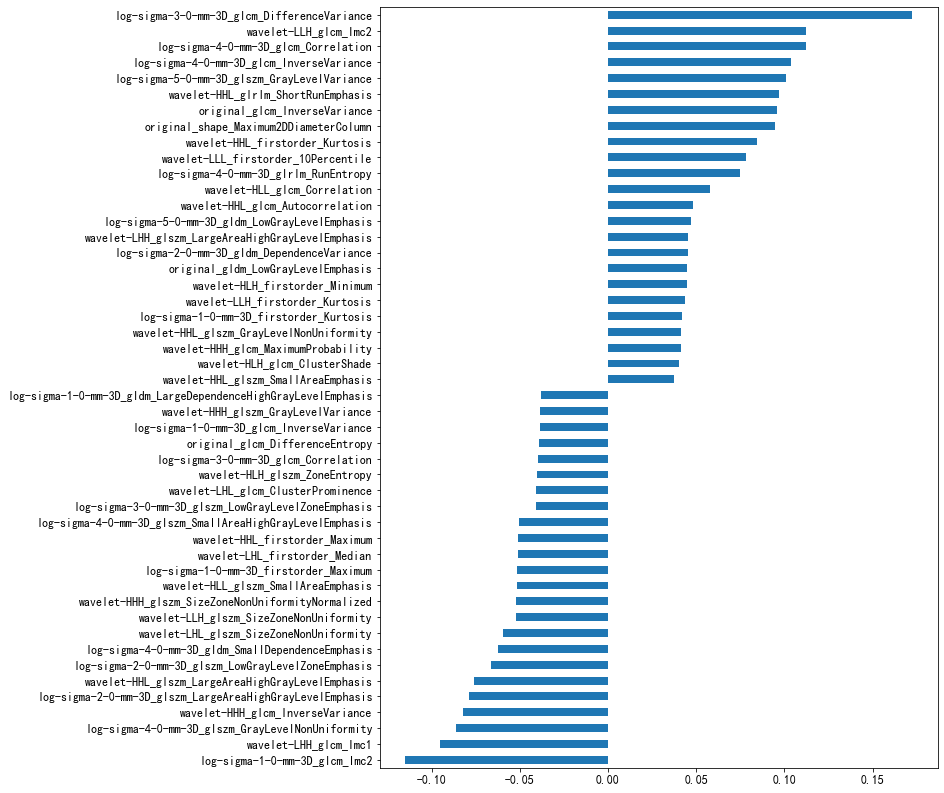

In [13]:
mpl.rcParams['font.sans-serif'] = ['SimHei'] 
mpl.rcParams['axes.unicode_minus'] = False
matplotlib.rcParams.update({'font.size': 12})
plt.figure(figsize=(10,14))
model_lasso = Lasso(alpha = model.alpha_, random_state=RANDOM_NUM).fit(X_train, y_train)
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
imp_coef = pd.concat([coef.sort_values().head(24),
                     coef.sort_values().tail(24)])
imp_coef.plot(kind='barh')

In [24]:
select_df = df.loc[:, selected_feat]
select_df = pd.concat([df[list(df.columns)[:3]], select_df], axis= 1)
display(select_df)
select_df.to_csv('./Selected_features.csv', index=False)

,origin_data,segment,label,log-sigma-1-0-mm-3D_firstorder_Kurtosis,log-sigma-1-0-mm-3D_firstorder_Maximum,log-sigma-1-0-mm-3D_firstorder_Range,log-sigma-1-0-mm-3D_glcm_ClusterProminence,log-sigma-1-0-mm-3D_glcm_ClusterShade,log-sigma-1-0-mm-3D_glcm_Contrast,log-sigma-1-0-mm-3D_glcm_Imc2,...,wavelet-LLH_glcm_JointEntropy,wavelet-LLH_gldm_DependenceVariance,wavelet-LLH_gldm_LargeDependenceHighGrayLevelEmphasis,wavelet-LLH_glszm_LargeAreaLowGrayLevelEmphasis,wavelet-LLH_glszm_SizeZoneNonUniformity,wavelet-LLH_glszm_ZoneEntropy,wavelet-LLL_firstorder_10Percentile,wavelet-LLL_firstorder_Skewness,wavelet-LLL_glcm_Contrast,wavelet-LLL_glszm_LargeAreaHighGrayLevelEmphasis
0,BAIYONGSHENG1.nii.gz,BAIYONGSHENG1_0001.nii.gz,0,2.055144,242.076202,405.280014,2303.796755,-44.189757,9.958816,0.865718,...,5.906344,4.293013,1391.422492,1.958643,20.367089,5.073926,1150.299982,0.995728,160.787309,2683.475410
1,BAIYONGSHENG1.nii.gz,BAIYONGSHENG1_0002.nii.gz,0,2.627274,135.455536,134.307635,29.168444,1.938963,3.045479,0.737145,...,4.567152,3.482249,342.929487,6.852642,4.612903,4.300498,1052.366593,0.376071,37.608736,789.144444
2,BAIYONGSHENG1.nii.gz,BAIYONGSHENG1_0003.nii.gz,0,3.219004,166.114014,255.961884,371.462219,-8.751316,4.589157,0.796911,...,5.180607,2.024004,731.806020,3.439325,5.173913,5.306171,1086.669822,0.933230,46.016433,1885.144509
3,BAIYONGSHENG1.nii.gz,BAIYONGSHENG1_0004.nii.gz,0,2.529064,98.607384,209.535767,95.730490,-0.708666,3.355756,0.653353,...,3.779616,9.597631,462.338926,94.595894,3.173913,4.175736,1055.095040,0.997224,38.536666,1023.366864
4,BAIYONGSHENG1.nii.gz,BAIYONGSHENG1_0005.nii.gz,0,2.499383,160.474472,237.794060,158.974396,2.875078,7.965677,0.735607,...,4.245911,11.276859,283.118280,53.822302,5.800000,4.593429,1054.998230,0.511582,56.402205,928.967914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,ZHANGXINJIE3.nii.gz,ZHANGXINJIE3_0001.nii.gz,1,4.818150,109.535469,230.215721,45.296569,0.036218,1.074620,0.607068,...,2.209482,32.565970,603.162051,20215.792101,1.375000,3.875000,1101.327856,0.945839,21.430750,10859.333333
611,ZHANGXINJIE3.nii.gz,ZHANGXINJIE3_0002.nii.gz,1,4.832718,73.651154,118.301136,9.680536,1.298523,0.759011,0.456666,...,0.930626,42.263985,328.327419,39466.678571,1.000000,2.807355,1222.837684,0.412219,5.384445,12784.360000
612,ZHANGXINJIE3.nii.gz,ZHANGXINJIE3_0003.nii.gz,1,5.567235,101.130440,147.126328,23.231820,3.258855,0.802003,0.559047,...,1.735308,34.658140,653.805693,23370.035714,1.285714,2.807355,1027.538837,1.520334,8.286626,12762.581006
613,ZHANGXINJIE3.nii.gz,ZHANGXINJIE3_0004.nii.gz,1,5.716176,83.379738,223.731483,71.605434,-1.880763,1.230469,0.681600,...,1.997433,23.153408,594.458874,12940.055556,1.000000,2.000000,1145.441347,1.180617,21.685966,3278.402985


In [20]:
X_train_lasso=X_train.loc[:, selected_feat]
X_train_lasso

,log-sigma-1-0-mm-3D_firstorder_Kurtosis,log-sigma-1-0-mm-3D_firstorder_Maximum,log-sigma-1-0-mm-3D_firstorder_Range,log-sigma-1-0-mm-3D_glcm_ClusterProminence,log-sigma-1-0-mm-3D_glcm_ClusterShade,log-sigma-1-0-mm-3D_glcm_Contrast,log-sigma-1-0-mm-3D_glcm_Imc2,log-sigma-1-0-mm-3D_glcm_InverseVariance,log-sigma-1-0-mm-3D_glcm_JointEnergy,log-sigma-1-0-mm-3D_glcm_JointEntropy,...,wavelet-LLH_glcm_JointEntropy,wavelet-LLH_gldm_DependenceVariance,wavelet-LLH_gldm_LargeDependenceHighGrayLevelEmphasis,wavelet-LLH_glszm_LargeAreaLowGrayLevelEmphasis,wavelet-LLH_glszm_SizeZoneNonUniformity,wavelet-LLH_glszm_ZoneEntropy,wavelet-LLL_firstorder_10Percentile,wavelet-LLL_firstorder_Skewness,wavelet-LLL_glcm_Contrast,wavelet-LLL_glszm_LargeAreaHighGrayLevelEmphasis
0,1.846879,-0.627591,-0.104474,-0.256230,-0.019220,-0.422989,-0.478472,0.544499,0.004414,-0.335063,...,-0.270410,0.861237,-0.915814,-0.244796,-0.607321,-0.031653,-0.377239,2.637851,-0.112614,-0.355641
1,2.154302,0.191333,0.013918,-0.245432,0.062666,-0.566190,-0.203421,0.711296,0.089526,-0.496349,...,-0.298904,-0.062188,-0.047223,-0.240464,-0.661686,-0.315197,-0.778097,-0.394967,-0.424187,-0.146707
2,6.660962,-0.582127,-0.956390,-0.274394,0.032768,-0.736469,-0.476945,-1.416714,2.121434,-1.710897,...,-1.432051,0.258942,-0.899345,-0.238091,-0.676430,-0.977707,-0.943038,-1.370646,-0.617208,-0.349467
3,0.844954,-0.832726,-0.596223,-0.254543,-0.101204,-0.565595,-0.438322,0.668704,0.198907,-0.523120,...,-1.359378,2.004925,0.126635,0.047055,-0.604654,-0.726526,-1.914850,0.619397,-0.362187,-0.268642
4,-1.064672,0.348946,-0.671103,-0.238281,-0.072676,-0.280960,0.314192,0.270057,2.241336,-1.625436,...,-0.949780,-1.495894,-1.350474,-0.257143,-0.132777,-1.734278,0.024887,-0.507066,-0.331479,-0.415373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
425,1.188565,1.012100,0.801229,-0.114102,0.419521,-0.269491,0.248475,0.338482,-0.335046,0.240502,...,-0.116517,1.252298,0.483416,-0.197014,-0.658709,0.064727,1.552001,1.283566,-0.059281,-0.061546
426,0.332924,-1.138548,-0.642202,-0.268271,-0.049377,-0.553725,-0.684607,0.729685,0.020372,-0.470718,...,-0.764755,1.025162,0.604563,-0.233482,-0.601485,-0.991661,-1.766041,0.026275,-0.406417,-0.233529
427,-1.063509,1.311936,1.319237,0.566694,-0.573888,1.372499,1.343076,-1.456121,-0.757090,1.622583,...,1.700578,-1.107421,-0.292154,-0.257008,0.535912,0.490839,0.712812,0.582312,1.722733,-0.317586
428,-0.444842,0.707573,0.322230,-0.229493,0.012467,-0.252790,-0.676410,0.481307,-0.476271,0.426398,...,0.767405,0.022140,1.257820,-0.253869,0.682622,1.463273,0.254634,0.010729,-0.172264,-0.126479


In [25]:
#所有数据分类十折交叉验证
def Kfold_model_confusion(model, X, y, name):
    cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1234)
    accuracy = cross_val_score(model,X, y, cv=cv,scoring="accuracy",n_jobs=-1)
    auc = cross_val_score(model,X, y, cv=cv,scoring="roc_auc",n_jobs=-1)
    recall = cross_val_score(model,X, y, cv=cv,scoring="recall",n_jobs=-1)
    precision = cross_val_score(model,X, y, cv=cv,scoring="precision",n_jobs=-1)
    f1 = cross_val_score(model,X, y, cv=cv,scoring="f1",n_jobs=-1)
    result_dict = {'Accuracy': [accuracy.mean()], 
                  'Auc': [auc.mean()], 
                  'Recall': [recall.mean()], 
                  'Precision': [precision.mean()],
                  'F1 score': [f1.mean()]}
    result = pd.DataFrame(result_dict, index=[name])
    return result

#创建分类器
lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier()
svm_clf = SVC(probability=True)
forest_clf = RandomForestClassifier(random_state=0,n_jobs=-1,class_weight="balanced")
gra_clf = GradientBoostingClassifier(n_estimators=500)
ada_clf = AdaBoostClassifier(n_estimators=500)
dt_clf = DecisionTreeClassifier(random_state=1234)
lgbm_clf = LGBMClassifier(n_estimators=500)
xgb_clf = xgboost.XGBClassifier(n_estimators=500, learning_rate=0.2, 
                                gamma=0.5, max_depth=20, verbosity=0)
en_clf = VotingClassifier(estimators=[('rf', forest_clf), ('gb', gra_clf), ('xgb', xgb_clf), ('lgbm', lgbm_clf)],
                         voting='soft',weights=[4, 3, 4, 5])


#训练分类器并输出结果
result3 = Kfold_model_confusion(lr_clf, X_train_lasso, y_train, 'Logistic Regression')
result3 = pd.concat([result3, Kfold_model_confusion(knn_clf, X_train_lasso, y_train, 'KNN')])
result3 = pd.concat([result3, Kfold_model_confusion(svm_clf, X_train_lasso, y_train, 'SVM')])
result3 = pd.concat([result3, Kfold_model_confusion(forest_clf, X_train_lasso, y_train, 'Random Forest')])
result3 = pd.concat([result3, Kfold_model_confusion(gra_clf, X_train_lasso, y_train, 'Gradient Boosting')])
result3 = pd.concat([result3, Kfold_model_confusion(ada_clf, X_train_lasso, y_train, 'AdaBoosting')])
result3 = pd.concat([result3, Kfold_model_confusion(dt_clf, X_train_lasso, y_train, 'Decision Tree')])
result3 = pd.concat([result3, Kfold_model_confusion(lgbm_clf,X_train_lasso, y_train, 'LGBM')])
result3 = pd.concat([result3, Kfold_model_confusion(xgb_clf, X_train_lasso, y_train, 'XGBoost')])
result3 = pd.concat([result3, Kfold_model_confusion(en_clf,X_train_lasso, y_train, 'Ensemble')])
result3

,Accuracy,Auc,Recall,Precision,F1 score
Logistic Regression,0.955814,0.972676,0.911376,0.949185,0.928542
KNN,0.804651,0.852009,0.631746,0.722181,0.665722
SVM,0.902326,0.967396,0.735185,0.945812,0.825932
Random Forest,0.904651,0.960114,0.786508,0.904145,0.838847
Gradient Boosting,0.913953,0.965377,0.845238,0.880793,0.862250
AdaBoosting,0.904651,0.947462,0.815608,0.877337,0.843912
Decision Tree,0.837209,0.823410,0.785979,0.735932,0.757075
LGBM,0.911628,0.960666,0.815608,0.895987,0.853261
XGBoost,0.906977,0.954813,0.815608,0.884799,0.847403
Ensemble,0.913953,0.966316,0.823016,0.898002,0.857323


C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (

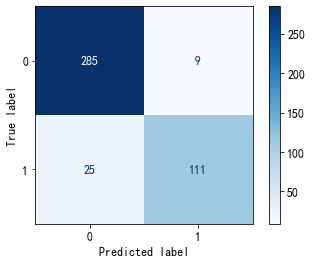

In [26]:
#混淆矩阵
clf=en_clf
cons = 0
#target_ = np.array(target, dtype = int)
cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=1)
for i, (train, test) in enumerate(cv.split(X_train_lasso, y_train)):
    clf.fit(X_train_lasso.iloc[train], y_train.iloc[train])
    class_names=['0','1']
    a=confusion_matrix(y_train.iloc[test],(clf.fit(X_train_lasso.iloc[train], y_train.iloc[train])).predict(X_train_lasso.iloc[test]))
    cons=cons+a
disp = ConfusionMatrixDisplay(confusion_matrix=cons,display_labels=class_names)
disp.plot(cmap = 'Blues')
plt.show()  

In [ ]:
cv = StratifiedKFold(n_splits=10,shuffle=True,random_state=1)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots()   
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
for i, (train, test) in enumerate(cv.split(X_train_lasso, y_train)):
    clf.fit(X_train_lasso.iloc[train], y_train.iloc[train])
    viz = plot_roc_curve(clf, X_train_lasso.iloc[test],y_train.iloc[test])
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2,color='r', 
         alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

ax.plot(mean_fpr, mean_tpr, 
        label=r'AUC = %0.2f'% (mean_auc),
        lw=2, alpha=.8)

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic")
ax.legend(loc="lower right")

plt.show()

In [27]:
#用selectbest对特征做方差分析F检验
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2,f_classif
model = SelectKBest(f_classif, k=44)
select_feature=model.fit_transform(X_train_lasso,y_train)
scores=model.pvalues_
indices=np.argsort(scores)[::-1]
print('Features ANOVA p_value')
#"%0.2f%s" % (scores[indices[i]],
for i in range(len(scores)):
    print("'"+X_train_lasso.columns[indices[i]]+"'"+",")


Features ANOVA p_value
'wavelet-LHL_firstorder_Skewness',
'wavelet-HHL_gldm_SmallDependenceLowGrayLevelEmphasis',
'log-sigma-3-0-mm-3D_glszm_SizeZoneNonUniformity',
'log-sigma-5-0-mm-3D_gldm_LowGrayLevelEmphasis',
'log-sigma-3-0-mm-3D_glcm_Contrast',
'wavelet-HLH_glrlm_RunVariance',
'wavelet-HLL_firstorder_Kurtosis',
'log-sigma-2-0-mm-3D_glszm_GrayLevelVariance',
'log-sigma-3-0-mm-3D_firstorder_Kurtosis',
'wavelet-LHL_firstorder_Kurtosis',
'wavelet-HHL_glcm_Autocorrelation',
'original_glcm_JointEntropy',
'log-sigma-2-0-mm-3D_glcm_ClusterProminence',
'log-sigma-3-0-mm-3D_glszm_LargeAreaHighGrayLevelEmphasis',
'original_gldm_LowGrayLevelEmphasis',
'wavelet-HHH_glcm_Idn',
'wavelet-LHH_gldm_DependenceVariance',
'wavelet-HHL_glszm_SmallAreaEmphasis',
'log-sigma-4-0-mm-3D_glszm_SmallAreaEmphasis',
'wavelet-LHH_glszm_SmallAreaLowGrayLevelEmphasis',
'wavelet-HLH_glszm_ZoneVariance',
'original_shape_Sphericity',
'log-sigma-4-0-mm-3D_gldm_SmallDependenceEmphasis',
'wavelet-LHH_firstorder_Kurtosi

C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
select_feature=['月经间隔天数',
'嗜碱性粒细胞绝对值',
'高血压史',
'谷酰转肽酶',
'睡眠时间',
'晚睡',
'血糖值',
'是否绝经',
'WHR',
'臀围',
'胡萝卜',
'运动量',
'白蛋白',
'白蛋白球蛋白比',
'噩梦',
'淋巴细胞比例',
'肌酐',
'中性粒细胞比例',
'失眠',
'空腹血糖.葡萄糖.',
'乳腺增生',
'二手烟',
'中性粒细胞绝对值',
'早醒',
'怀孕次数',
'母乳喂养月数',
'奶制品',
'孩子个数',
'城市/农村ur',
'生活满意度',
'经济状况',
'家庭月均收入',
'行为预防得分']

In [ ]:
X_train_imp=X_train.loc[:, select_feature]
X_train_imp

In [ ]:
#所有数据分类十折交叉验证
def Kfold_model_confusion(model, X, y, name):
    cv = StratifiedKFold(n_splits=10,shuffle=True,random_state=1234)
    accuracy = cross_val_score(model,X, y, cv=cv,scoring="accuracy",n_jobs=-1)
    auc = cross_val_score(model,X, y, cv=cv,scoring="roc_auc",n_jobs=-1)
    recall = cross_val_score(model,X, y, cv=cv,scoring="recall",n_jobs=-1)
    precision = cross_val_score(model,X, y, cv=cv,scoring="precision",n_jobs=-1)
    f1 = cross_val_score(model,X, y, cv=cv,scoring="f1",n_jobs=-1)
    result_dict = {'Accuracy': [accuracy.mean()], 
                  'Auc': [auc.mean()], 
                  'Recall': [recall.mean()], 
                  'Precision': [precision.mean()],
                  'F1 score': [f1.mean()]}
    result = pd.DataFrame(result_dict, index=[name])
    return result

#创建分类器
lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier()
svm_clf = SVC(probability=True)
forest_clf = RandomForestClassifier(random_state=0,n_jobs=-1,class_weight="balanced")
gra_clf = GradientBoostingClassifier(n_estimators=500)
ada_clf = AdaBoostClassifier(n_estimators=500)
dt_clf = DecisionTreeClassifier(random_state=1234)
lgbm_clf = LGBMClassifier(n_estimators=500)
xgb_clf = xgboost.XGBClassifier(n_estimators=500, learning_rate=0.2, 
                                gamma=0.5, max_depth=20, verbosity=0)
en_clf = VotingClassifier(estimators=[('rf', forest_clf), ('gb', gra_clf), ('xgb', xgb_clf), ('lgbm', lgbm_clf)],
                         voting='soft',weights=[4, 3, 4, 5])


#训练分类器并输出结果
result3 = Kfold_model_confusion(lr_clf, X_train_imp, y_train, 'Logistic Regression')
result3 = pd.concat([result3, Kfold_model_confusion(knn_clf, X_train_imp, y_train, 'KNN')])
result3 = pd.concat([result3, Kfold_model_confusion(svm_clf, X_train_imp, y_train, 'SVM')])
result3 = pd.concat([result3, Kfold_model_confusion(forest_clf, X_train_imp, y_train, 'Random Forest')])
result3 = pd.concat([result3, Kfold_model_confusion(gra_clf, X_train_imp, y_train, 'Gradient Boosting')])
result3 = pd.concat([result3, Kfold_model_confusion(ada_clf, X_train_imp, y_train, 'AdaBoosting')])
result3 = pd.concat([result3, Kfold_model_confusion(dt_clf, X_train_imp, y_train, 'Decision Tree')])
result3 = pd.concat([result3, Kfold_model_confusion(lgbm_clf,X_train_imp, y_train, 'LGBM')])
result3 = pd.concat([result3, Kfold_model_confusion(xgb_clf, X_train_imp, y_train, 'XGBoost')])
result3 = pd.concat([result3, Kfold_model_confusion(en_clf,X_train_imp, y_train, 'Ensemble')])
result3